# Đánh giá mô hình phát hiện ký tự trên biển số với tập dữ liệu biển số Việt Nam 
---

## Nhập thư viện

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import sys
sys.path.append(os.path.abspath('yolov5'))
from yolov5.utils.general import non_max_suppression
from yolov5.utils.dataloaders import letterbox  
from typing import List
from yolov5.models.experimental import attempt_load
import cv2
import math

## Nhập mô hình

In [120]:
model_path = 'char_custom.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = attempt_load(model_path, device=device)  # load FP32 model

Fusing layers... 
custom_model_char summary: 146 layers, 4852562 parameters, 0 gradients, 13.8 GFLOPs


## Các hàm hỗ trợ

In [121]:
def load_image(image_path, img_size = 128):
    """
        Hàm load ảnh từ đường dẫn, trả về tensor đã được chuẩn hóa
    """
    img = cv2.imread(image_path)
    img = letterbox(img, img_size)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB
    img = np.ascontiguousarray(img) / 255.0 # normalize to [0, 1]

    img_tensor = torch.from_numpy(img).float().unsqueeze(0)
    return img_tensor

In [122]:
def detect(model, img_tensor, conf_thres=0.25, iou_thres=0.45):
    """
        Hàm thực hiện phát hiện đối tượng trong ảnh
    """
    model.eval()
    with torch.no_grad():
        pred = model(img_tensor)[0]
        pred = non_max_suppression(pred, conf_thres, iou_thres)
    return pred

In [123]:
def distance(xyxy1, xyxy2):
    x1, y1, x2, y2 = xyxy1
    x1_, y1_, x2_, y2_ = xyxy2
    return math.sqrt(((x1 + x2) / 2 - (x1_ + x2_) / 2) ** 2 + ((y1 + y2) / 2 - (y1_ + y2_) / 2) ** 2)

def filter_bbox(pred, min_distance=10):
    """
    Lọc các bounding box gần nhau, giữ lại bounding box có confidence cao hơn.
    """
    pred = pred[0] if isinstance(pred, list) else pred  # Đảm bảo đầu vào là tensor
    keep = torch.ones(len(pred), dtype=torch.bool)
    
    for i, det1 in enumerate(pred):
        if not keep[i]:
            continue
        for j, det2 in enumerate(pred):
            if i != j and keep[j]:
                if distance(det1[:4], det2[:4]) < min_distance:
                    if det1[4] < det2[4]:
                        keep[i] = False
                        break
                    else:
                        keep[j] = False
    
    return [pred[keep]]

In [124]:
def extract_plate_label(pred, class_names=None, var_thres = 0.4):
    """
        Hàm trích xuất nhãn biển số từ kết quả phát hiện
    """
    if not pred: return ""

    centers = []
    for det in pred:
        for x1, y1, x2, y2, conf, cls in det:
            center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
            label = class_names[int(cls)] if class_names else f'{conf:.2f}'
            centers.append((center_x, center_y, label, y2 - y1))

    if len(centers) < 2: return ""

    X, Y = np.array([c[0] for c in centers]), np.array([c[1] for c in centers])
    m, b = np.linalg.lstsq(np.vstack([X, np.ones(len(X))]).T, Y, rcond=None)[0]

    residuals = np.abs(Y - (m * X + b))
    avg_bbox_height = np.mean([c[3] for c in centers])
    var_thresh = avg_bbox_height * var_thres

    if np.var(residuals) < var_thresh:
        return "".join(label for _, _, label, _ in sorted(centers))
    
    line1, line2 = [], []
    for x, y, label, _ in centers:
        (line1 if y < m*x + b else line2).append((x, label))
    return "".join("".join(label for _, label in sorted(line)) for line in [line1, line2] if line)

## Nhập dữ liệu 

In [125]:
df = pd.read_csv('crop_labels.csv')
df['Label'] = df['Label'].str.replace(" ", "")
df.drop(columns=['Type'], inplace=True)

In [126]:
df

,Name,Label
0,car_1.jpg,30F11292
1,car_2.jpg,30F78286
2,car_3.jpg,30F90230
3,car_4.jpg,30E49536
4,car_5.jpg,98A29814
...,...,...
6638,type7_995.jpg,72H01719
6639,type7_996.jpg,72H00538
6640,type7_997.jpg,72C06086
6641,type7_998.jpg,92H01008


## Đánh giá mô hình

In [127]:
class_names = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z'
]

dir_path = 'cropped/'
conf_thres = 0.1
iou_thres = 0.04


for index, row in df.iterrows():
    image_path = row['Name']
    image_path = os.path.join(dir_path, image_path)
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        continue
    img_tensor = load_image(image_path)
    pred = detect(model, img_tensor, conf_thres, iou_thres)
    
    if pred[0] is not None:
        pred = filter_bbox(pred)
        plate_label = extract_plate_label(pred, class_names=class_names, var_thres=0.45)
        df.at[index, 'Predicted_Label'] = plate_label
    else:
        df.at[index, 'Predicted_Label'] = ""

In [128]:
df['Predicted_Label'] = df['Predicted_Label'].str.upper()

In [129]:
df

,Name,Label,Predicted_Label
0,car_1.jpg,30F11292,30F11292
1,car_2.jpg,30F78286,3DF78286
2,car_3.jpg,30F90230,90F90230
3,car_4.jpg,30E49536,30E49536
4,car_5.jpg,98A29814,98A29814
...,...,...,...
6638,type7_995.jpg,72H01719,72ND771
6639,type7_996.jpg,72H00538,72D5
6640,type7_997.jpg,72C06086,EF
6641,type7_998.jpg,92H01008,R1DB


In [130]:
# Tính độ chính xác
correct_predictions = (df['Label'] == df['Predicted_Label']).sum()
total_predictions = len(df)

accuracy = correct_predictions / total_predictions

# In kết quả độ chính xác
print(correct_predictions)
print(f"Accuracy: {accuracy:.4f}")

495
Accuracy: 0.0745


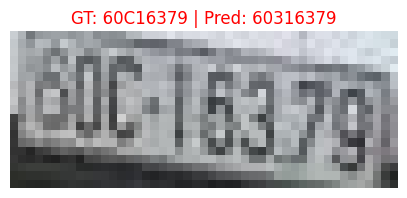

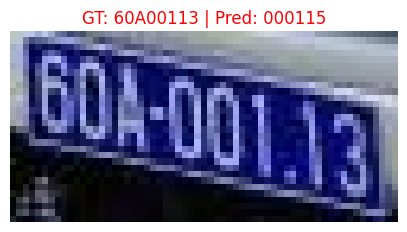

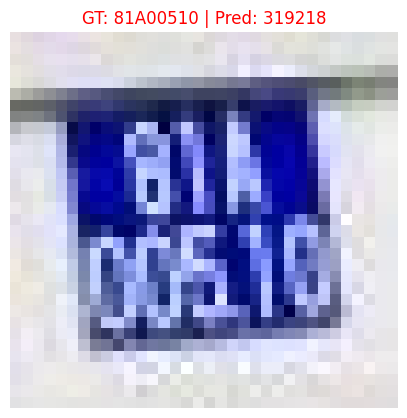

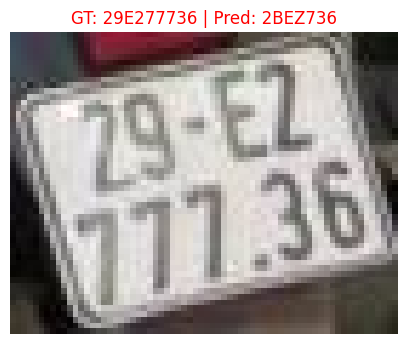

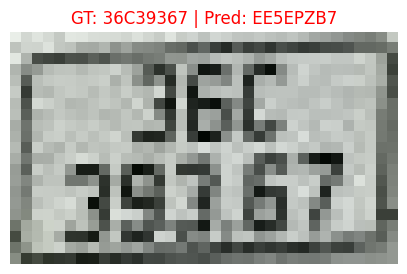

In [136]:
incorrect_predictions = df[df['Label'] != df['Predicted_Label']].sample(n=5, random_state=44)

# Hiển thị ảnh bị dự đoán sai
%matplotlib inline
for index, row in incorrect_predictions.iterrows():
    image_path = os.path.join(dir_path, row["Name"])  # Thay bằng đường dẫn thực tế
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"GT: {row['Label']} | Pred: {row['Predicted_Label']}", fontsize=12, color='red')
        plt.show()
    else:
        print(f"Ảnh {row['Name']} không tồn tại.")

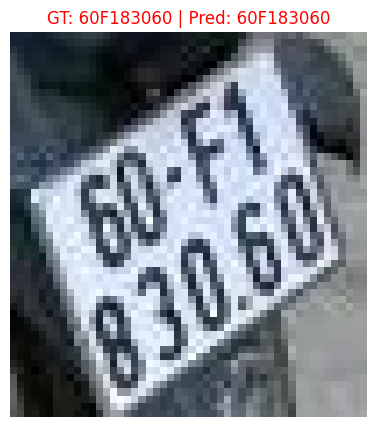

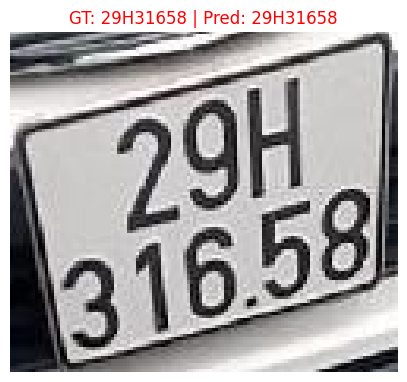

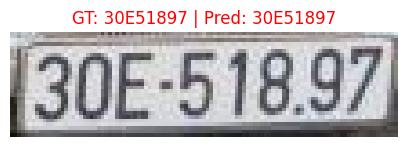

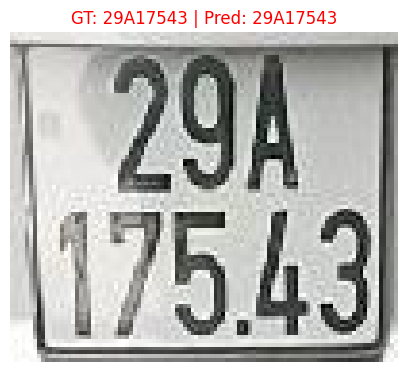

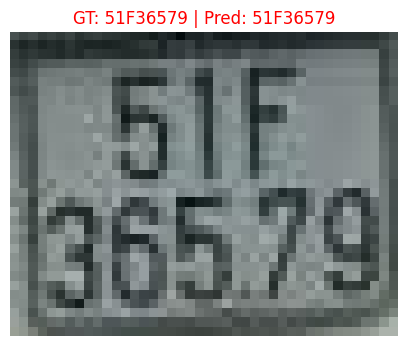

In [132]:
incorrect_predictions = df[df['Label'] == df['Predicted_Label']].sample(n=5, random_state=42)

# Hiển thị ảnh bị dự đoán sai
%matplotlib inline
for index, row in incorrect_predictions.iterrows():
    image_path = os.path.join(dir_path, row["Name"])  # Thay bằng đường dẫn thực tế
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"GT: {row['Label']} | Pred: {row['Predicted_Label']}", fontsize=12, color='red')
        plt.show()
    else:
        print(f"Ảnh {row['Name']} không tồn tại.")